# Final Project
### Import precomp libs

In [1]:
import spacy
nlp = spacy.load('en') # this should take some time like 10s to load
%load_ext line_profiler

In [2]:
test_loc = 'test_dump.bin'
train_loc = 'train_dump.bin'

In [180]:
from spacy.tokens.doc import Doc
import pickle 
import numpy as np
import scipy as sp
import pandas as pd
from collections import Counter
from sklearn.feature_extraction import DictVectorizer
from scipy.sparse import coo_matrix, hstack
from datetime import datetime
import nltk

In [59]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier

In [33]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
print train.shape, test.shape
target = train['is_duplicate']

(404290, 6) (2345796, 3)


In [5]:
docs = []
i = 0
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
with open(train_loc, 'rb') as file_:
    for byte_string in Doc.read_bytes(file_):
        if i%10000 == 0: print i, datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        docs.append(Doc(nlp.vocab).from_bytes(byte_string))
        i += 1
#         if i == 10: break
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print(type(docs[0]))

2017-05-14 16:01:18
0 2017-05-14 16:01:18
10000 2017-05-14 16:01:21
20000 2017-05-14 16:01:22
30000 2017-05-14 16:01:23
40000 2017-05-14 16:01:24
50000 2017-05-14 16:01:25
60000 2017-05-14 16:01:26
70000 2017-05-14 16:01:27
80000 2017-05-14 16:01:28
90000 2017-05-14 16:01:29
100000 2017-05-14 16:01:30
110000 2017-05-14 16:01:31
120000 2017-05-14 16:01:32
130000 2017-05-14 16:01:33
140000 2017-05-14 16:01:34
150000 2017-05-14 16:01:35
160000 2017-05-14 16:01:35
170000 2017-05-14 16:01:36
180000 2017-05-14 16:01:37
190000 2017-05-14 16:01:38
200000 2017-05-14 16:01:39
210000 2017-05-14 16:01:40
220000 2017-05-14 16:01:41
230000 2017-05-14 16:01:42
240000 2017-05-14 16:01:43
250000 2017-05-14 16:01:44
260000 2017-05-14 16:01:45
270000 2017-05-14 16:01:45
280000 2017-05-14 16:01:46
290000 2017-05-14 16:01:47
300000 2017-05-14 16:01:48
310000 2017-05-14 16:01:49
320000 2017-05-14 16:01:50
330000 2017-05-14 16:01:51
340000 2017-05-14 16:01:52
350000 2017-05-14 16:01:53
360000 2017-05-14 16:0

In [28]:
def wordPairs(docs):
    fvs = []
    for i in range(0,len(docs),2):
        if i % 100000 == 0: print i
        fv = {}
        d1 = docs[i]
        d2 = docs[i+1]
        
        w1 = [word.lemma_ for word in d1 if not word.is_stop and word.pos is not 95]
        w2 = [word.lemma_  for word in d2 if not word.is_stop and word.pos is not 95]
        
        s1 = set([word.lemma_ for word in d1 if not word.is_stop and word.pos is not 95])
        s2 = set([word.lemma_  for word in d2 if not word.is_stop and word.pos is not 95])
        
        diff = s1 ^ s2
        same =  s1 & s2

        same = Counter([w for w in same])
        fv.update(same)

        diff = Counter([w + '_d' for w in diff])
        fv.update(diff)

        fvs.append(fv)
        
    return fvs

In [29]:
fvs = wordPairs(docs)

0
100000
200000
300000
400000
500000
600000
700000
800000


In [88]:
from sklearn.feature_extraction.text import TfidfTransformer
v = DictVectorizer()
t = TfidfTransformer(smooth_idf=False)

In [176]:
X = v.fit_transform(fvs)
# X = t.fit_transform(counts)

In [177]:
X.shape

(404290, 112503)

#### Validation

In [114]:
# Training classifiers

mnb = MultinomialNB()
sdg = SGDClassifier(loss='log')
lr = LogisticRegression()
eclf = VotingClassifier(estimators=[('mn', clf1), ('sgd', clf2), ('lr', clf3)], voting='soft', weights=[1,1,4])

# scores = cross_val_score(eclf, X, target, cv=3, scoring='neg_log_loss')
# print "Log Loss: %0.5f" % scores.mean()

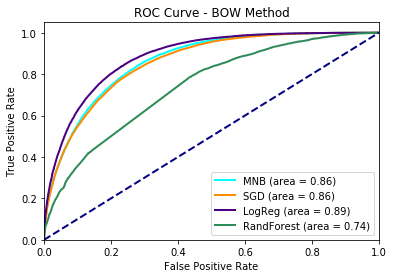

In [179]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=.2)
clfs = [('MNB', MultinomialNB(alpha=1)), ('SGD', SGDClassifier(loss='log')), ('LogReg', LogisticRegression()), ('RandForest', RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=50, min_samples_split=30, min_samples_leaf=8))]

colors = cycle(['cyan', 'darkorange','indigo', 'seagreen', 'blue', ])

for (clfname, clf), color in zip(clfs, colors):
    y_score = zip(*clf.fit(X_train, y_train).predict_proba(X_test))[1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    rocauc = auc(fpr, tpr)
    lw = 2
    plt.plot(fpr, tpr, color=color, lw=lw, label=clfname + ' (area = %0.2f)' % rocauc)
    
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - BOW Method')
plt.legend(loc="lower right")
plt.savefig("roc.pdf")
plt.show()

In [174]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
clfs = [MultinomialNB(alpha=1), SGDClassifier(loss='log'), LogisticRegression(), RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=50, min_samples_split=30, min_samples_leaf=8, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, oob_score=False, n_jobs=-1, warm_start=True, class_weight=None)]
n_classes = 2
for clf in clfs:
    print clf
    scores = cross_val_score(clf, X, target, cv=3, scoring='neg_log_loss')
    print "Log Loss: %0.5f" % scores.mean()

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)
Log Loss: -0.45464
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
Log Loss: -0.52297
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Log Loss: -0.42771
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=8,
            min_samples_split=30, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, rand

### Testing

In [99]:
test_docs = []
i = 0
with open(test_loc, 'rb') as file_:
    for byte_string in Doc.read_bytes(file_):
        test_docs.append(Doc(nlp.vocab).from_bytes(byte_string))
        i += 1

In [106]:
test_docs.shape

AttributeError: 'list' object has no attribute 'shape'

In [100]:
fv_test = wordPairs(test_docs)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000


In [101]:
fv_test = v.transform(fv_test)

In [108]:
fv_test.shape

(2345796, 112503)

In [109]:
clf = LogisticRegression().fit(X, target)
prob = clf.predict_proba(fv_test)
prob.shape

(2345796, 2)

In [111]:
# prob[:10]

array([[ 0.98636744,  0.01363256],
       [ 0.40524307,  0.59475693],
       [ 0.20237894,  0.79762106],
       [ 0.51767534,  0.48232466],
       [ 0.33427601,  0.66572399],
       [ 0.90114111,  0.09885889],
       [ 0.20541736,  0.79458264],
       [ 0.01588863,  0.98411137],
       [ 0.50495695,  0.49504305],
       [ 0.98423735,  0.01576265]])

In [113]:
f = open('submission', 'w')
f.write('test_id,is_duplicate\n')
for i, p in enumerate(prob):
    f.write(str(i) + ',' + str(p[1]) + '\n')
f.close()